In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import librosa

import sys
sys.path.append('Datasets/')
sys.path.append('models/')

import torch
import datasets
import models
import audio_utils

In [3]:
model = models.ASC_Model00(return_second_last=False)
model.load_state_dict(torch.load('ASC_Model01_tut_20epochs_sr32000_statedict.pt'))

<All keys matched successfully>

In [6]:
#TUT_DF = pd.read_csv(datasets.TUT_TEST_CSV)
TUT_BASELINE_PREDS = pd.read_csv('predictions/TUT18_test_baseline__sr32000_predictions.csv')
tut_scenes = TUT_BASELINE_PREDS['preds'].unique()

true_preds = TUT_BASELINE_PREDS[TUT_BASELINE_PREDS['labels'] == TUT_BASELINE_PREDS['preds']]

In [17]:
scapper_preds = pd.read_csv('predictions/scrapper_test_baseline_sr32000.csv')
scapper_scenes = scapper_preds['preds'].unique()

true_preds = scapper_preds[scapper_preds['acoustic_scene_label'] == scapper_preds['preds']]

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

def get_logMel_from_fname(audio_fname):
    audio = audio_utils.load_audio_from_file(audio_fname, sample_rate=32000)
    log_mel = audio_utils.get_log_melSpectrogram(audio)
    return log_mel

def zero_signal(log_mel, index):
    log_mel[0][index] = torch.ones(log_mel[0][index].shape) * log_mel.min()
    return log_mel

def run_loop(audio_fname, model):
    feat_inva_output_list = []
    input_feats = get_logMel_from_fname(audio_fname)

    n_features = input_feats.shape[1]

    for i in range(n_features):
        input_feats = get_logMel_from_fname(audio_fname)
        input_log_mel = zero_signal(input_feats, i)

        model.eval()
        with torch.inference_mode():
            predictions = model(input_log_mel.unsqueeze(0).to(device))
            predictions = tut_scenes[torch.argmax(torch.sigmoid(predictions.cpu()))]
        feat_inva_output_list.append(predictions)
    return feat_inva_output_list

In [8]:
feat_ablation_preds = {i:[] for i in tut_scenes}
random_files = []

for i in tut_scenes:
    random.seed(42)
    random_files.append(random.sample(true_preds[true_preds['labels'] == i]['files'].tolist(), 10))

for i in range(len(tut_scenes)):
    for j in random_files[i]:
        feat_ablation_preds[tut_scenes[i]].append(run_loop(os.path.join(datasets.TUT_AUD_DIR,j), model))


In [71]:
len(feat_ablation_preds['airport'][0])

40

In [9]:
feat_ablation = {i:[0 for j in range(40)] for i in tut_scenes}

for i in tut_scenes:
    for j in range(len(feat_ablation_preds[i])):
        for k in range(len(feat_ablation_preds[i][j])):
            if i != feat_ablation_preds[i][j][k]:
                feat_ablation[i][k] += 1


<Axes: title={'center': 'Feature ablation for tut18 test set using Baseline+sr32000 model'}>

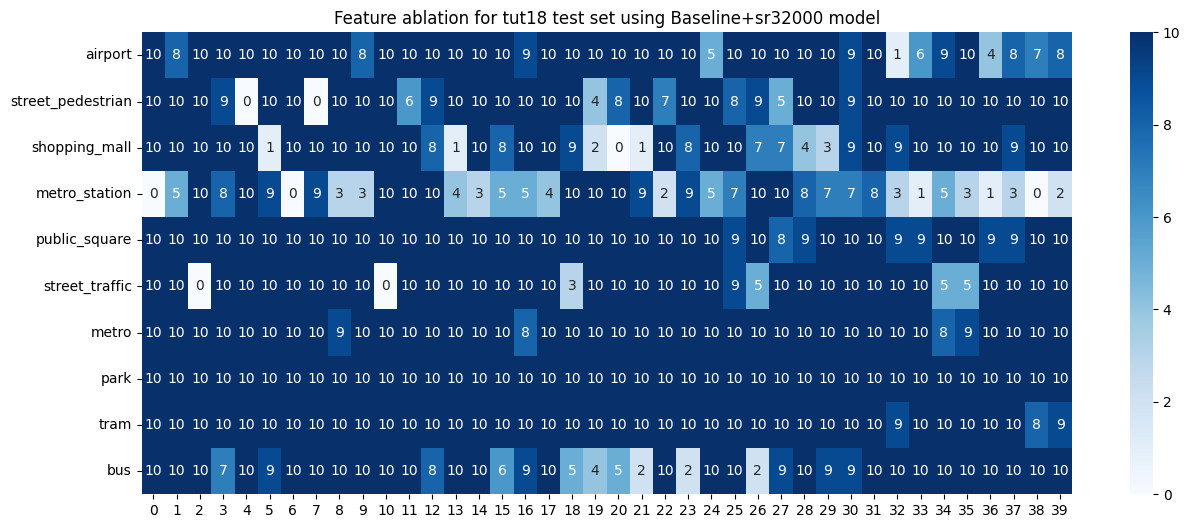

In [10]:
plt.figure(figsize=(15,6))
plt.title('Feature ablation for tut18 test set using Baseline+sr32000 model')
sns.heatmap(pd.DataFrame(feat_ablation).transpose(), fmt='d', annot=True, cmap='Blues', yticklabels=tut_scenes)

<Axes: title={'center': 'Confusion matrix for baseline model (sr32000) on tut18 test set'}>

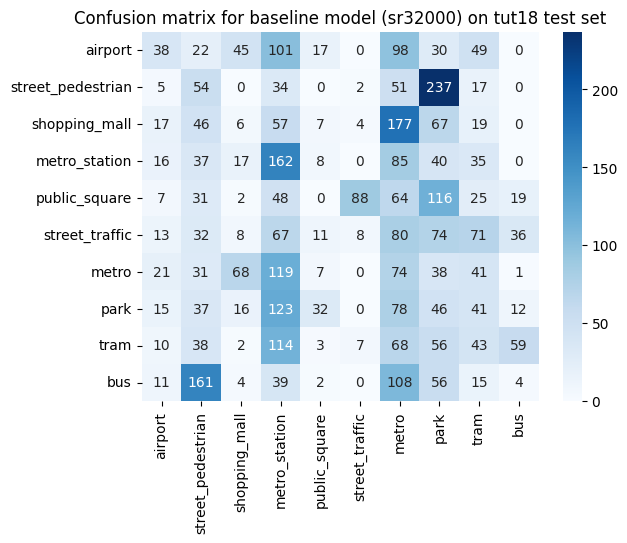

In [12]:
tru = []
preds = []

for i in tut_scenes:
    for j in range(len(feat_ablation_preds[i])):
        for k in range(len(feat_ablation_preds[i][j])):
            tru.append(i)
            preds.append(feat_ablation_preds[i][j][k])

cm = confusion_matrix(tru, preds)
plt.title('Confusion matrix for baseline model (sr32000) on tut18 test set')
sns.heatmap(cm, annot=True, fmt='d', xticklabels=tut_scenes, yticklabels=tut_scenes, cmap='Blues')

In [23]:
model

ASC_Model00(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=2048, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=2048, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)